In [1]:
!pip install -q torchsummaryX
!pip3 install torchvision
!python -m spacy download en
!pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pytorch-nlp

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torchsummaryX import summary

from UDA_pytorch_utils import UDA_LSTMforSequential, UDA_pytorch_classifier_fit, \
    UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
    UDA_compute_accuracy

In [3]:
filename = 'roi.plot.genresplitted.tsv'
df = pd.read_csv(filename, sep='\t')
df.head()

,tconst,name,date,prod_budget,domestic_gross,worldwide_gross,isAdult,startYear,runtimeMinutes,Action,Adventure,Drama,Fantasy,Sci-Fi,Thriller,Animation,Comedy,Family,Crime,Horror,History,Romance,Mystery,Musical,Documentary,Adult,War,Biography,Western,Sport,Music,News,Film-Noir,ROI_domestic,ROI_worldwide,plot
0,tt4154796,Avengers: Endgame,2019,400000000,858373000,2797800564,0,2019,181,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.145932,6.994501,"In the opening, Clint Barton is teaching his d..."
1,tt1298650,Pirates of the Caribbean: On Stranger Tides,2011,379000000,241063875,1045663875,0,2011,136,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.636052,2.759008,Captain Jack Sparrow (Johnny Depp) travels to ...
2,tt2395427,Avengers: Age of Ultron,2015,365000000,459005868,1403013963,0,2015,141,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.257550,3.843874,"In the Eastern European country of Sokovia, th..."
3,tt4154756,Avengers: Infinity War,2018,300000000,678815482,2048359754,0,2018,149,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.262718,6.827866,SPOILER: Thanos and his Children - Proxima Mid...
4,tt0974015,Justice League,2017,300000000,229024295,655945209,0,2017,120,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.763414,2.186484,The film opens with camera phone footage of Cl...


In [4]:
train_dataset = df[['ROI_domestic', 'plot']].values.tolist()
new_traindataset = []
for data in train_dataset:
    dict_object = {}
    dict_object['text'] = data[1]
    dict_object['roi'] = data[0]
    new_traindataset.append(dict_object)
train_dataset = new_traindataset
print(train_dataset[0])

{'text': 'In the opening, Clint Barton is teaching his daughter archery on his secluded farm while his wife prepares a picnic lunch for them. Suddenly, Clint\'s daughter vanishes and the rest of Clint\'s family disintegrates, along with half of all life across the universe, the result of Thanos\' snapping his fingers after acquiring all six Infinity Stones. Nebula and Tony Stark are stranded in space following their defeat by Thanos on Titan, but are returned to Earth by Carol Danvers and reunited with Natasha Romanoff, Bruce Banner, Steve Rogers, Rocket, Thor, and James Rhodes. The team formulates a plan to steal the Infinity Stones back from Thanos and use them to reverse his actions, but learn upon finding him that he had used the stones a second time to destroy them, preventing their further use. He tells the remaining Avengers that he did so to avoid using the Stones for further nefarious purposes. Enraged, Thor cuts off Thanos\' head, saying it\'s what he should have done in Waka

In [0]:
import re
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

for data in train_dataset:
    data['text'] = remove_special_characters(data['text'], remove_digits=True)

In [0]:
proper_train_size = int(len(df) * 0.8)
val_size = len(df) - proper_train_size

In [0]:
proper_train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,
                                                                  [proper_train_size,
                                                                   val_size])

In [0]:
from torchnlp.encoders.text import SpacyEncoder

In [0]:
encoder = SpacyEncoder([data['text'] for data in proper_train_dataset])

In [0]:
proper_train_encoded = [encoder.encode(data['text']) for data in proper_train_dataset]

In [0]:
proper_train_labels = torch.tensor([int(data['roi'] < 2) for data in proper_train_dataset])

In [24]:
# the proportion of true data in train set
np.sum([int(data['roi'] < 2) for data in proper_train_dataset])/len(proper_train_dataset)

0.7135638297872341

In [0]:
val_encoded = [encoder.encode(data['text']) for data in val_dataset]

In [0]:
val_labels = torch.tensor([int(data['roi'] < 2) for data in val_dataset])

In [23]:
# the proportion of true data in validation set
np.sum([int(data['roi'] < 2) for data in val_dataset])/len(val_dataset)

0.7148936170212766

In [0]:
proper_train_dataset_encoded = list(zip(proper_train_encoded, proper_train_labels))
val_dataset_encoded = list(zip(val_encoded, val_labels))

In [0]:
from torchnlp.word_to_vector import GloVe
pretrained_embedding = GloVe(name='6B', dim=100)

In [0]:
embedding_weights = torch.Tensor(encoder.vocab_size, pretrained_embedding.dim)
for i, token in enumerate(encoder.vocab):
    embedding_weights[i] = pretrained_embedding[token]

In [0]:
simple_lstm_model = nn.Sequential(nn.Embedding.from_pretrained(embedding_weights),
                                  UDA_LSTMforSequential(100, 64),
                                  nn.Linear(64, 2))

In [18]:
summary(simple_lstm_model, torch.zeros((1, 5), dtype=torch.long))

                Kernel Shape Output Shape   Params Mult-Adds
Layer                                                       
0_0             [100, 90071]  [1, 5, 100]        -         -
1_1.LSTM_model             -   [1, 5, 64]  42.496k   41.984k
2_2                  [64, 2]       [1, 2]    130.0     128.0
-------------------------------------------------------------
                         Totals
Total params          9.049726M
Trainable params        42.626k
Non-trainable params    9.0071M
Mult-Adds               42.112k


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[100, 90071]","[1, 5, 100]",NaN,NaN
1_1.LSTM_model,-,"[1, 5, 64]",42496.0,41984.0
2_2,"[64, 2]","[1, 2]",130.0,128.0


Epoch 1 [==================================================] 3760/3760
  Train accuracy: 0.7130319148936171
  Validation accuracy: 0.7170212765957447
Epoch 2 [==================================================] 3760/3760
  Train accuracy: 0.7135638297872341
  Validation accuracy: 0.7170212765957447
Epoch 3 [==================================================] 3760/3760
  Train accuracy: 0.7138297872340426
  Validation accuracy: 0.7159574468085106
Epoch 4 [==================================================] 3760/3760
  Train accuracy: 0.7135638297872341
  Validation accuracy: 0.7180851063829787
Epoch 5 [==================================================] 3760/3760
  Train accuracy: 0.7135638297872341
  Validation accuracy: 0.7159574468085106
Epoch 6 [==================================================] 3760/3760
  Train accuracy: 0.7109042553191489
  Validation accuracy: 0.7138297872340426
Epoch 7 [==================================================] 3760/3760
  Train accuracy: 0.711702127

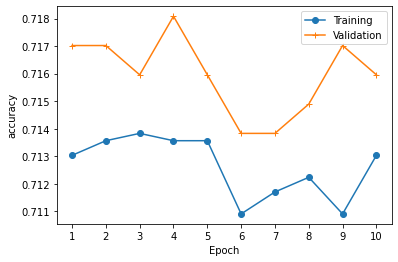

In [20]:
num_epochs = 10  # during optimization, how many times we look at training data
batch_size = 32  # during optimization, how many training data to use at each step
learning_rate = 0.01  # during optimization, how much we nudge our solution at each step

train_recalls, val_recalls = \
    UDA_pytorch_classifier_fit(simple_lstm_model,
                               torch.optim.Adam(simple_lstm_model.parameters(),
                                                lr=learning_rate),
                               nn.CrossEntropyLoss(),  # includes softmax
                               proper_train_dataset_encoded, val_dataset_encoded,
                               num_epochs, batch_size, metric='accuracy', sequence=True)

UDA_plot_train_val_accuracy_vs_epoch(train_recalls, val_recalls, 'accuracy')